In [1]:
#| default_exp wrapping

In [416]:
#| export

from blender_tissue_cartography import io as tcio
from blender_tissue_cartography import registration as tcreg

import numpy as np
from copy import deepcopy
import warnings
import igl

from scipy import sparse

In [3]:
from blender_tissue_cartography import interpolation as tcinterp
from skimage import transform
from scipy import stats, spatial, linalg
import os
import matplotlib.pyplot as plt
import mcubes

In [4]:
from tqdm.notebook import tqdm
from importlib import reload

In [5]:
np.set_printoptions(suppress=True)

In [6]:
from scipy import interpolate

## Automated wrapping

This notebook builds the tools for automated mesh wrapping (setting vertex positions of one mesh to the closest point on another mesh). This is a part of the pipeline for dynamic surfaces discussed in notebook 3a.

Here, we implement wrapping using `libigl`

## Loading and segmenting the dataset

We will use the same dataset - a _Drosophila_ example - as in tutorial 2.

In [7]:
metadata_dict = {'filename': 'wrapping_example/Drosophila_CAAX-mCherry',
                 'resolution_in_microns': (1.05, 1.05, 1.05), # lightsheet data has isotropic resolution
                 'subsampling_factors': (1/2, 1/2, 1/2),
                }

In [8]:
image = tcio.adjust_axis_order(tcio.imread(f"{metadata_dict['filename']}.tif"))
print("image shape:", image.shape) # image shape - spatial axes are in z-x-y order

image shape: (1, 190, 509, 188)


## 3d segmentation / Meshing

Already done - we'll just read in the results.

## Registration

Using the tools from notebook 3a, compute an affine registration of the reference onto the data mesh.

In [9]:
mesh_data = tcio.ObjMesh.read_obj(f"{metadata_dict['filename']}_mesh_remeshed.obj")
mesh_ref = tcio.ObjMesh.read_obj(f"wrapping_example/Drosophila_reference.obj")

/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/io.py:202: RuntimeWarning: Warning: multiple meshes in .obj file
  warnings.warn(f"Warning: multiple meshes in .obj file", RuntimeWarning)


In [10]:
trafo_centroid_intertia, _ = tcreg.align_by_centroid_and_intertia(mesh_ref.vertices, mesh_data.vertices,
                                                                  q=0.01, shear=True)

trafo_icp, _, _ = tcreg.icp(mesh_ref.vertices, mesh_data.vertices, initial=trafo_centroid_intertia,
                            threshold=1e-4, max_iterations=100, scale=True, n_samples=5000)

In [11]:
# we now save the pre-registered mesh. Note that we want to transform both our
# mesh coordinates and the corresponding normals, as well as potentially flip face orientation

mesh_registered = mesh_ref.apply_affine_to_mesh(trafo_icp)
mesh_registered.name = "Drosophila_reference_preregistered"
mesh_registered.write_obj(f"wrapping_example/Drosophila_reference_registered.obj")

## Procedural wrapping

We can also automatically wrap using blender's python API. Let's see how it works. 
- Annoyingly, blender scripts cannot be directly run from python. It must be done from within the blender script window. The goal here would be to write a script that can be either easily run in blender, or run from the command line (also possible via python's `shutil`).
- `pymeshlab`'s `transfer_attributes_per_vertex`
- `libigl`'s `point_mesh_squared_distance`
- `trimesh.proximity`
- `open3d` - see [here](https://www.open3d.org/docs/latest/tutorial/geometry/distance_queries.html).



In [111]:
reload(tcio)

<module 'blender_tissue_cartography.io' from '/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/io.py'>

### Smoothing in `libigl`

We implement Laplacian and Taubin smoothing for vertex positions using `libigl`'s Laplacian operator.

In [497]:
#| export

def get_uniform_laplacian(tris, normalize=True):
    """
    Get uniform Laplacian (purely connectivity based) as sparse matrix.
    
    If normalize, the diagonal = -1. Else, diagonal equals number of neighbors.
    """
    a = igl.adjacency_matrix(tris)
    a_sum = np.squeeze(np.asarray(a.sum(axis=1)))
    a_diag = sparse.diags(a_sum)
    if normalize:
        return sparse.diags(1/a_sum)@(a - a_diag)
    return (a - a_diag)

In [538]:
#| export

def smooth_laplacian(mesh: tcio.ObjMesh, lamb=0.5, n_iter=10, method="explicit") -> tcio.ObjMesh:
    """
    Smooth using Laplacian filter.
    
    Assumes mesh is triangular.
    
    Parameters
    ----------
    mesh : ObjMesh
        Initial mesh.
    lamb : float, default 0.5
        Filter strength. Higher = more smoothing.
    n_iter : int
        Filter iterations
    method : str, default "explicit"
        Can use explicit (fast, simple) or implicit (slow, more accurate) method.

    Returns
    -------
    mesh_smoothed : ObjMesh
        Smoothed mesh.

    """
    if not mesh.is_triangular:
        warnings.warn(f"Warning: mesh not triangular - result may be incorrect", RuntimeWarning)
    v_smoothed = np.copy(mesh.vertices)
    f = mesh.tris
    if method == "implicit":
        laplacian = igl.cotmatrix(v, f)
        for _ in range(n_iter):
            mass = igl.massmatrix(v_smoothed, f, igl.MASSMATRIX_TYPE_BARYCENTRIC)
            v_smoothed = sparse.linalg.spsolve(mass - lamb * laplacian, mass.dot(v_smoothed))
    elif method == "explicit":
        laplacian_uniform = get_uniform_laplacian(f)
        for _ in range(n_iter):
            v_smoothed += lamb*laplacian_uniform.dot(v_smoothed)
    mesh_smoothed = tcio.ObjMesh(v_smoothed, mesh.faces, texture_vertices=mesh.texture_vertices,
                                 normals=None, name=mesh.name)
    mesh_smoothed.set_normals()
    return mesh_smoothed

In [539]:
mesh_smoothed = smooth_laplacian(mesh_wrapped, lamb=0.5, n_iter=10, method="explicit")

In [540]:
mesh_smoothed.write_obj("wrapping_example/Drosophila_reference_smoothed_uniform_igl.obj")

In [542]:
#| export

def smooth_taubin(mesh: tcio.ObjMesh, lamb=0.5, nu=0.53, n_iter=10,) -> tcio.ObjMesh:
    """
    Smooth using Taubin filter (like Laplacian, but avoids shrinkage).
    
    Assumes mesh is triangular. See   "Improved Laplacian Smoothing of Noisy Surface Meshes"
    J. Vollmer, R. Mencl, and H. Muller.
    
    Parameters
    ----------
    mesh : ObjMesh
        Initial mesh.
    lamb : float, default 0.5
        Filter strength. Higher = more smoothing.
    nu : float, default 0.53
        Counteract shrinkage. Higher = more dilation.
    n_iter : int
        Filter iterations

    Returns
    -------
    mesh_smoothed : ObjMesh
        Smoothed mesh.

    """
    if not mesh.is_triangular:
        warnings.warn(f"Warning: mesh not triangular - result may be incorrect", RuntimeWarning)
    v_smoothed = np.copy(mesh.vertices)
    laplacian_uniform = get_uniform_laplacian(mesh.tris)
    for _ in range(n_iter):
        v_smoothed += lamb*laplacian_uniform.dot(v_smoothed)
        v_smoothed -= nu*laplacian_uniform.dot(v_smoothed)
    mesh_smoothed = tcio.ObjMesh(v_smoothed, mesh.faces, texture_vertices=mesh.texture_vertices,
                                 normals=None, name=mesh.name)
    mesh_smoothed.set_normals()
    return mesh_smoothed

In [543]:
mesh_smoothed_taubin = smooth_taubin(mesh_wrapped, lamb=0.5, nu=0.53, n_iter=10)

In [545]:
mesh_smoothed_taubin.write_obj("wrapping_example/Drosophila_reference_smoothed_taubin_igl.obj")

### `libigl`

In [89]:
# Load source and target mesh
mesh_target = tcio.ObjMesh.read_obj("wrapping_example/Drosophila_CAAX-mCherry_mesh_remeshed.obj")
mesh_source = tcio.ObjMesh.read_obj("wrapping_example/Drosophila_reference_registered.obj")

In [90]:
# compute closest point on target mesh for each source vertex
distances, indices, points = igl.point_mesh_squared_distance(mesh_source.vertices,
                                                             mesh_target.vertices, mesh_target.tris)

In [91]:
# points are closest points on the surface, not necessarily vertices
np.linalg.norm(points[10]-mesh_target.vertices, axis=1).min()

2.522711587899371

In [92]:
# indices are triangle indices
indices.max(), mesh_target.vertices.shape[0]

(16845, 8425)

In [97]:
mesh_wrapped = tcio.ObjMesh(points, mesh_source.faces, texture_vertices=mesh_source.texture_vertices,
                            normals=None, name=mesh_source.name)
mesh_wrapped.set_normals()

In [116]:
mesh_wrapped.write_obj("wrapping_example/Drosophila_reference_wrapped_igl.obj")

In [546]:
#| export

def shrinkwrap_igl(mesh_source, mesh_target, n_iter_smooth_target=10, n_iter_smooth_wrapped=10):
    """
    Shrink-wrap the source mesh onto the target mesh using trimesh.
    
    Sets the vertex positions of mesh_source to the closes point on the surface of mesh_target (not necessarily
    a vertex). Optionally, smoothes the target mesh and the wrapped mesh for smoother results using a Taubin
    filter (recommended). Gives out a warning if the shrink-wrapping flips any vertex normals, which can
    indicate problems.
    
    The shrinkwrapped mesh still has the UV maps of the source mesh, and so can be used to compute
    cartographic projections. Assumes mesh is triangular.
    
    Parameters
    ----------
    mesh_source : tcio.ObjMesh
        Mesh to be deformed
    mesh_target : tcio.ObjMesh
        Mesh with target shape
    n_iter_smooth_target : int, default 10
        Taubin smoothing iterations for target
    n_iter_smooth_wrapped : int, default 10
        Taubin smoothing iterations for shrinkwrapped mesh, after shrinkwrapping

    Returns
    -------
    mesh_wrapped : tcio.ObjMesh

    """
    if not mesh.is_triangular:
        warnings.warn(f"Warning: mesh not triangular - result may be incorrect", RuntimeWarning)
    # smooth if necessary
    if n_iter_smooth_target > 0:
        target_verts = smooth_taubin(mesh_target, n_iter=n_iter_smooth_target).vertices
    else:
        target_verts = mesh_target.vertices
    # compute closest point on target mesh for each source vertex
    distances, indices, points = igl.point_mesh_squared_distance(mesh_source.vertices,
                                                                 target_verts, mesh_target.tris)
    # create wrapped mesh
    mesh_wrapped = tcio.ObjMesh(points, mesh_source.faces, texture_vertices=mesh_source.texture_vertices,
                            normals=None, name=mesh_source.name)
    mesh_wrapped.set_normals()
    if n_iter_smooth_wrapped > 0:
        mesh_wrapped = smooth_taubin(mesh_wrapped, n_iter=n_iter_smooth_wrapped)
    # check if any normals were flipped
    dots = np.einsum("vi,vi->v", mesh_source.normals, mesh_wrapped.normals)
    if np.sum(dots < 0) > 0:
        warnings.warn(f"Warning: {np.sum(dots<0)} normal(s) flipped during shrink-wrapping", RuntimeWarning)
    return mesh_wrapped

In [547]:
%%time
mesh_wrapped = shrinkwrap_igl(mesh_source, mesh_target)

CPU times: user 468 ms, sys: 0 ns, total: 468 ms
Wall time: 339 ms


In [548]:
mesh_wrapped.write_obj("wrapping_example/Drosophila_reference_wrapped_igl.obj")

## UV projection

To see how well all of this has worked, let's use the wrapped mesh to generate UV projections.

In [550]:
normal_offsets = np.array([-4, -2, 0, 2]) ##np.linspace(-5, 2, 8) # in microns
metadata_dict["normal_offsets"] = normal_offsets # add the info to the metadata
uv_grid_steps = 512

In [551]:
tcio.save_dict_to_json(f"{metadata_dict['filename']}_metadata.json", metadata_dict)

In [552]:
projected_data_wrapped, projected_coordinates_wrapped, projected_normals_wrapped = tcinterp.create_cartographic_projections(
    image=f"{metadata_dict['filename']}.tif",
    mesh=f"wrapping_example/Drosophila_reference_wrapped_igl.obj",
    resolution=metadata_dict["resolution_in_microns"],
    normal_offsets=normal_offsets,
    uv_grid_steps=uv_grid_steps)

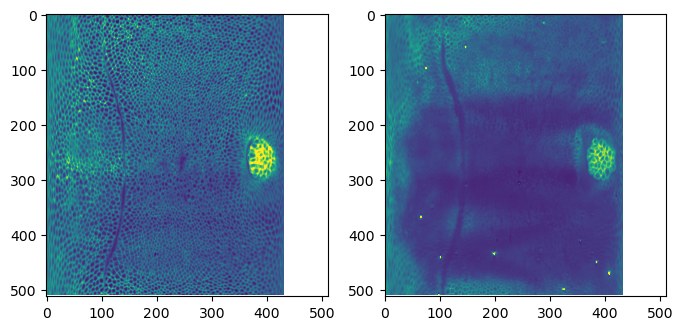

In [553]:
# show the projected data - looks good!

fig, (ax1, ax2) = plt.subplots(figsize=(8,8), ncols=2)
ax1.imshow(projected_data_wrapped[0, 0], vmax=10000)
ax2.imshow(projected_data_wrapped[0, 2], vmax=10000)